In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

def findFiles(path): 
  return glob.glob(path)

print('Files:',findFiles('data/*.txt'))


all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print('A simple example: ',unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

Files: ['data/Czech.txt', 'data/Japanese.txt', 'data/Chinese.txt', 'data/Vietnamese.txt', 'data/English.txt', 'data/Polish.txt', 'data/French.txt', 'data/Russian.txt', 'data/German.txt', 'data/Portuguese.txt', 'data/Italian.txt', 'data/Korean.txt', 'data/Scottish.txt', 'data/Dutch.txt', 'data/Irish.txt', 'data/Spanish.txt', 'data/Greek.txt', 'data/Arabic.txt']
A simple example:  Slusarski


In [ ]:
print(category_lines['Spanish'][:5])

['Abana', 'Abano', 'Abarca', 'Abaroa', 'Abascal']


In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
input = lineToTensor('Augusto')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8346, -2.9569, -2.8178, -2.7867, -2.8943, -2.9201, -2.8425, -2.9335,
         -2.9715, -2.8271, -2.9865, -2.9503, -2.8762, -2.7974, -2.9777, -2.9843,
         -2.8640, -2.8453]], grad_fn=<LogSoftmaxBackward>)


In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 3)


In [ ]:
import random

def randomChoice(choice):
    return choice[random.randint(0, len(choice) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Avgerinos
category = German / line = Kassmeyer
category = Scottish / line = Black
category = French / line = Favre
category = Polish / line = Miazga
category = Arabic / line = Abboud
category = Korean / line = Ku
category = Czech / line = Opp
category = Polish / line = Niemec
category = Spanish / line = Abarca


In [ ]:
lossFunction = nn.NLLLoss()

In [ ]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = lossFunction(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.6018 Shirasu / Russian ✗ (Japanese)
10000 10% (0m 10s) 2.5576 Serafim / Greek ✗ (Portuguese)
15000 15% (0m 14s) 3.8625 Close / French ✗ (Greek)
20000 20% (0m 19s) 1.8240 Metz / German ✓
25000 25% (0m 24s) 0.5254 Schwarzenberg / Dutch ✓
30000 30% (0m 29s) 1.1820 Kulhanek / Czech ✓
35000 35% (0m 34s) 0.9727 Esteves / Portuguese ✓
40000 40% (0m 39s) 1.9516 Jelobinsky / Polish ✗ (Russian)
45000 45% (0m 44s) 2.9174 Ichimonji / Polish ✗ (Japanese)
50000 50% (0m 48s) 0.7314 Paredes / Portuguese ✓
55000 55% (0m 53s) 0.9551 D'cruze / Portuguese ✓
60000 60% (0m 58s) 0.8486 Turchi / Italian ✓
65000 65% (1m 3s) 1.0569 Bitar / Arabic ✓
70000 70% (1m 8s) 0.5499 Koolen / Dutch ✓
75000 75% (1m 13s) 0.0148 Kaminaga / Japanese ✓
80000 80% (1m 18s) 3.9155 Laar / Chinese ✗ (Dutch)
85000 85% (1m 23s) 0.4760 Rocha / Portuguese ✓
90000 90% (1m 28s) 2.1824 Prehatney / Russian ✗ (Czech)
95000 95% (1m 33s) 2.4203 Rousseau / Arabic ✗ (French)
100000 100% (1m 38s) 0.0933 Jluktov / Russian ✓


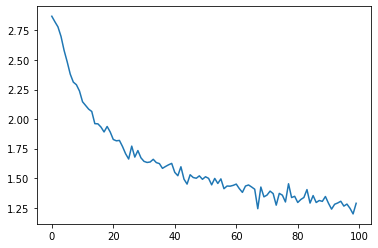

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

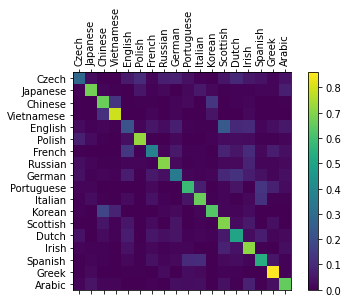

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Augusto')
predict('Jackson')
predict('Gustavo')
predict('Ellie')
predict('Chang')


> Augusto
(-0.96) Italian

> Jackson
(-0.24) Scottish

> Gustavo
(-1.45) Japanese

> Ellie
(-0.92) Scottish

> Chang
(-1.24) Irish
